# Prédiction du nombre de passagers aériens mensuels
Ce notebook présente une approche de prédiction du nombre de passagers aériens à partir du jeu de données classique **AirPassengers**.

In [ ]:
# 1. Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

## 2. Chargement et visualisation du jeu de données
Nous chargeons le jeu de données AirPassengers et visualisons l'évolution mensuelle du nombre de passagers.

In [ ]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url)
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


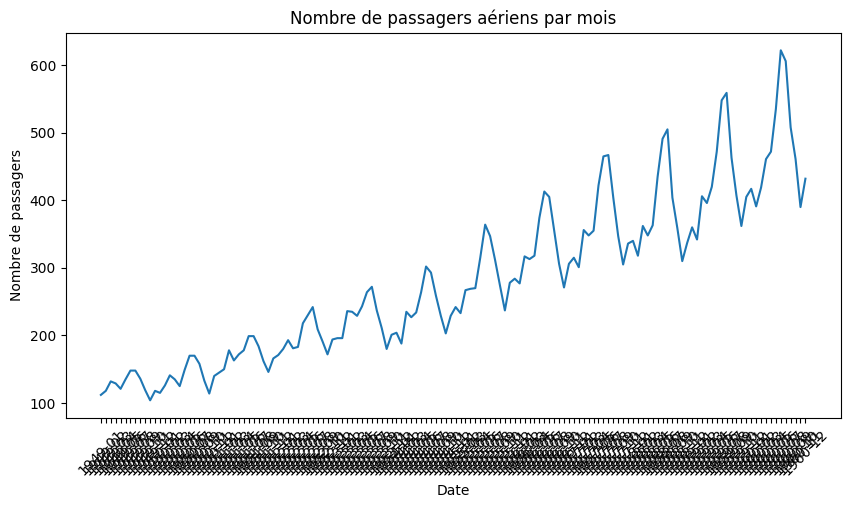

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df['Month'], df['Passengers'])
plt.xlabel('Date')
plt.ylabel('Nombre de passagers')
plt.title('Nombre de passagers aériens par mois')
plt.xticks(rotation=45)
plt.show()

## 3. Prétraitement des données
Nous sélectionnons la colonne du nombre de passagers et appliquons une normalisation Min-Max.  
Ensuite, nous créons des séquences temporelles pour l’entraînement du modèle.

In [ ]:
data = df['Passengers'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 12
X, y = create_sequences(data_scaled, SEQ_LENGTH)

## 4. Séparation des jeux d’entraînement et de test
Nous utilisons 80% des données pour l’entraînement et le reste pour le test.

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (105, 12, 1)
y_train shape: (105, 1)


## 5. Construction et entraînement du modèle LSTM
Nous construisons un modèle séquentiel avec une couche LSTM suivie d'une couche Dense.

In [ ]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

## 6. Prédiction et visualisation des résultats
Nous prédisons les valeurs du jeu de test et comparons avec les valeurs réelles.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


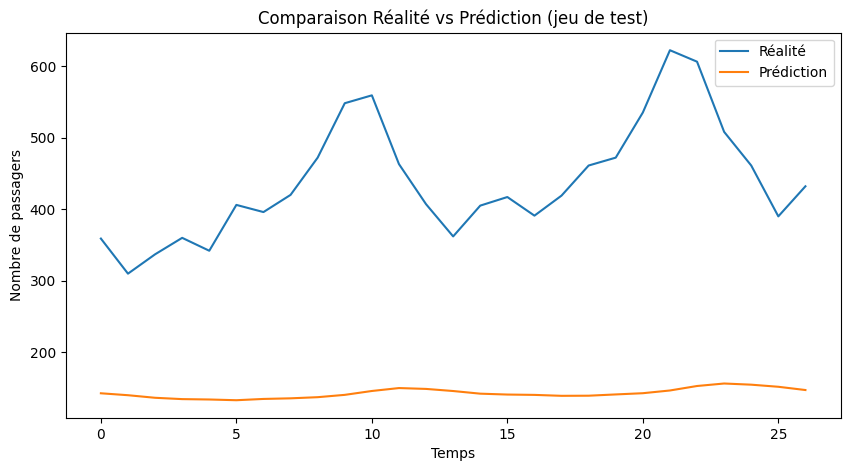

In [ ]:
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

plt.figure(figsize=(10,5))
plt.plot(range(len(y_test_inv)), y_test_inv, label='Réalité')
plt.plot(range(len(y_pred_inv)), y_pred_inv, label='Prédiction')
plt.legend()
plt.xlabel('Temps')
plt.ylabel('Nombre de passagers')
plt.title('Comparaison Réalité vs Prédiction (jeu de test)')
plt.show()

## 7. Évaluation de la performance du modèle
Nous calculons l’erreur quadratique moyenne (MSE) sur le jeu de test.

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f"Erreur quadratique moyenne (MSE) sur le jeu de test : {mse:.2f}")

Erreur quadratique moyenne (MSE) sur le jeu de test : 93685.23
